### import modules

In [23]:
import numpy as np
import pandas as pd
from pykrx import stock
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
 
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 한국 ticker 불러오기

In [2]:
# get kor tickers
    
def return_name(market):
    '''get name from ticker'''
    Market = []
    for ticker in market:
        Value =stock.get_market_ticker_name(ticker)
        Market.append([Value,ticker])
 
    df = pd.DataFrame(Market,columns=['회사명','상장번호'])
    return df

KOSPI = stock.get_market_ticker_list(market="KOSPI")
KOSDAQ = stock.get_market_ticker_list(market="KOSDAQ")

kospi = return_name(KOSPI)
kosdaq = return_name(KOSDAQ)

In [3]:
kospi.info() # KOSPI

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   회사명     943 non-null    object
 1   상장번호    943 non-null    object
dtypes: object(2)
memory usage: 14.9+ KB


In [4]:
kospi[kospi['회사명'] == '삼성전자'].values

array([['삼성전자', '005930']], dtype=object)

In [5]:
kospi[kospi['회사명'] == '삼성전자'].values[0][1]

'005930'

In [6]:
# get stock price of samsung
df = stock.get_market_ohlcv_by_date("20160104", "20230222", "005930")
df.tail()   

,시가,고가,저가,종가,거래량,거래대금,등락률
날짜,,,,,,,
2023-02-16,62500,63700,62400,63700,13798831,873759607962,2.41
2023-02-17,62900,63300,62400,62600,10791265,677809979471,-1.73
2023-02-20,62900,63000,61800,62700,12908073,806198780800,0.16
2023-02-21,62700,62800,62000,62100,7665046,476711896776,-0.96
2023-02-22,61500,61800,61000,61100,11959088,732238903100,-1.61


# 시가총액 4대 기업 포트폴리오

In [7]:
# 시가총액 4대 기업 주식정보가져오기

stocks=['삼성전자','LG에너지솔루션','SK하이닉스','삼성바이오로직스']
df_res = pd.DataFrame()

for i in stocks:
    ticker = kospi[kospi['회사명'] == i].values[0][1]
    df_res[i] = stock.get_market_ohlcv_by_date("20190101", "20230225", ticker)['종가']

In [8]:
df_res.info() # LG에너지솔루션 2022년 1월 27일자로 상장

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1026 entries, 2019-01-02 to 2023-02-24
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   삼성전자      1026 non-null   int32  
 1   LG에너지솔루션  266 non-null    float64
 2   SK하이닉스    1026 non-null   int32  
 3   삼성바이오로직스  1026 non-null   int32  
dtypes: float64(1), int32(3)
memory usage: 28.1 KB


## EDA

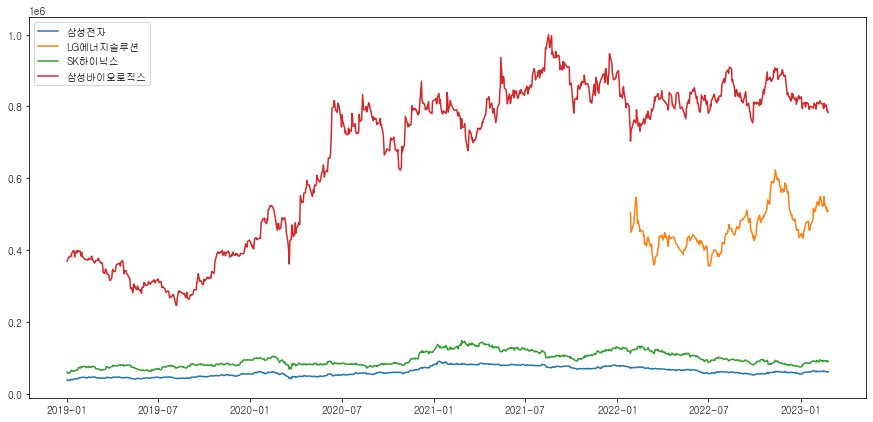

In [9]:
plt.figure(figsize=(15,7))
for i in stocks:
    plt.plot(df_res.index,df_res[i], label = i)
plt.legend(loc = 2)
plt.show();

### histogram

In [10]:
ret_daily = df_res.pct_change( )
ret_daily.head()

,삼성전자,LG에너지솔루션,SK하이닉스,삼성바이오로직스
날짜,,,,
2019-01-02,NaN,NaN,NaN,NaN
2019-01-03,-0.029677,NaN,-0.047855,0.006685
2019-01-04,-0.003989,NaN,0.010399,0.011951
2019-01-07,0.034713,NaN,0.006861,0.018373
2019-01-08,-0.016774,NaN,0.008518,-0.005156


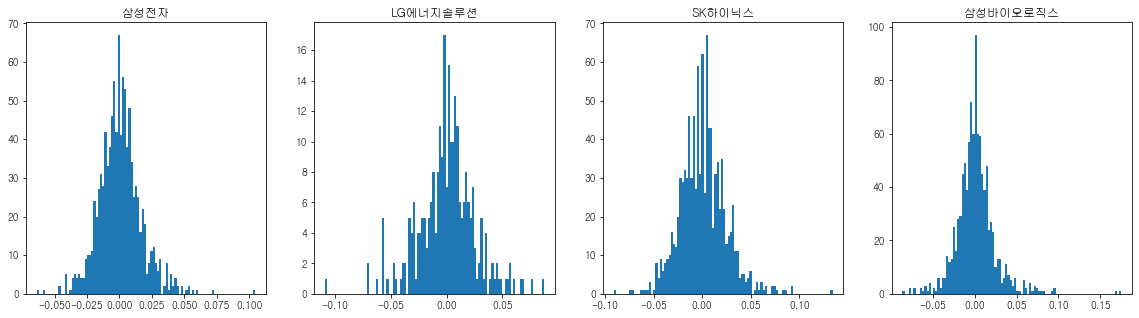

In [11]:
plt.figure(figsize=(25,5))

for i, t in enumerate(stocks):
    plt.subplot(151+i)
    plt.hist(ret_daily[t], bins=100)
    plt.title(t)

In [12]:
ret_daily_cs = ret_daily.cumsum()
ret_daily_cs.head()

,삼성전자,LG에너지솔루션,SK하이닉스,삼성바이오로직스
날짜,,,,
2019-01-02,NaN,NaN,NaN,NaN
2019-01-03,-0.029677,NaN,-0.047855,0.006685
2019-01-04,-0.033667,NaN,-0.037456,0.018636
2019-01-07,0.001046,NaN,-0.030595,0.037009
2019-01-08,-0.015728,NaN,-0.022077,0.031853


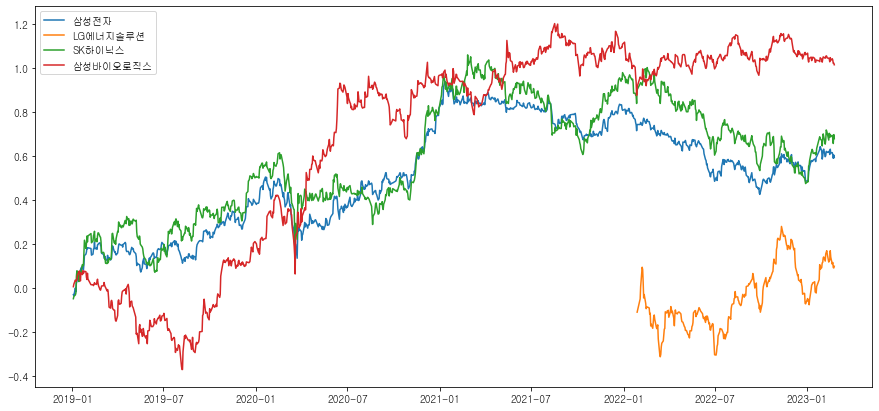

In [13]:
plt.figure(figsize=(15,7))
for i in stocks:
    plt.plot(ret_daily_cs.index,ret_daily_cs[i], label = i)
plt.legend(loc = 2)
plt.show();

# Efficient Invest line
- Monte Carlo simulation

In [14]:
# get return and risk
daily_ret = df_res.pct_change()           # pct_change() : get daily rate of return
annual_ret = daily_ret.mean() * 252       # yearly rate of return = daily mean * 252(business day)

daily_cov = daily_ret.cov()               # daily risk
annual_cov = daily_cov * 252              # yearly risk = daily risk * 252(business day)

# get random portfolio weight
weights = np.random.random(len(stocks)) # weights of stocks
weights /= np.sum(weights)        # sum of weights = 1

# risk-free rate: KOFR, policy rate
rf = 0.035

In [15]:
port_ret = []       # portfolio return
port_risk = []      # portfolio risk
port_weights = []   # weights
sharpe_ratio = []   # sharpe ratio = return/risk

for _ in range(20000):                         # generate 20000 cases
    
    weights = np.random.random(len(stocks))    # get weights 
    weights /= np.sum(weights)                 

    returns = np.dot(weights, annual_ret) - rf      # portfolio return = weights * returns , excess return
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))    # portfolio risk = weights * risks

    # append values to lists
    port_ret.append(returns)                     
    port_risk.append(risk) 
    port_weights.append(weights) 
    sharpe_ratio.append(returns/risk)           

    
# get dict of Retunrs, Risk, Sharpe, Weights
portfolio = {'Returns': port_ret, 'Risk': port_risk, 'Sharpe' : sharpe_ratio}
for i, s in enumerate(stocks): 
    portfolio[s] = [weight[i] for weight in port_weights] 
    
# from dict to dataframe
df = pd.DataFrame(portfolio) 
df = df[['Returns', 'Risk','Sharpe'] + [s for s in stocks]] 

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Returns   20000 non-null  float64
 1   Risk      20000 non-null  float64
 2   Sharpe    20000 non-null  float64
 3   삼성전자      20000 non-null  float64
 4   LG에너지솔루션  20000 non-null  float64
 5   SK하이닉스    20000 non-null  float64
 6   삼성바이오로직스  20000 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


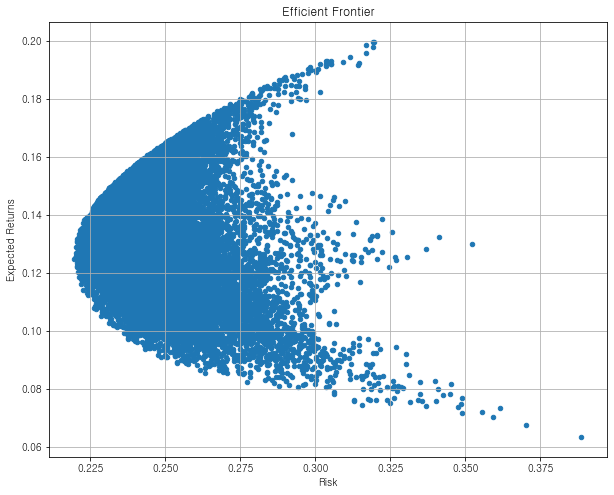

In [17]:
# draw scatter plot
df.plot.scatter(x='Risk', y='Returns', figsize=(10, 8), grid=True)
plt.title('Efficient Frontier') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.show();

# Mean-Varinance portfolio

In [18]:
# Mean-Varinance portfolio : Maximum of Sharpe Ratio(tangent portfolio)
max_sharpe = df.loc[df['Sharpe'] ==df['Sharpe'].max()]

# Mininum-Variance portfolio : Minimum of Variance
min_risk = df.loc[df['Risk'] == df['Risk'].min()]

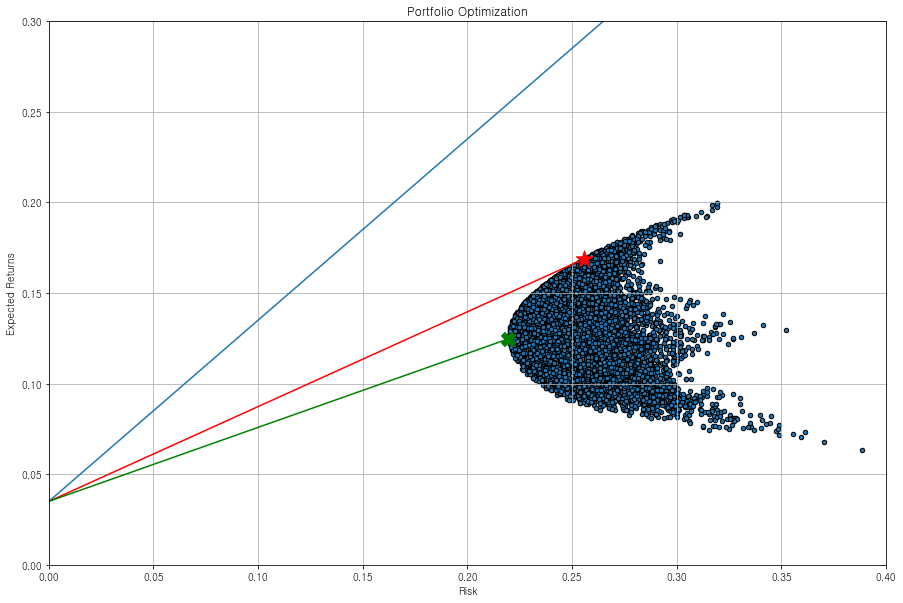

In [19]:
df.plot.scatter(x='Risk', y='Returns', #c='Sharpe', 
                cmap='viridis', edgecolors='k', 
                figsize=(15,10), grid=True) 

plt.scatter(x = max_sharpe['Risk'], y = max_sharpe['Returns'], 
            c ='r', marker='*', s = 300)       # Mean-Varinance portfolio: *
plt.scatter(x = min_risk['Risk'], y = min_risk['Returns'], 
            c = 'g', marker='X', s = 200)      # Mininum-Variance portfolio: X

plt.title('Portfolio Optimization') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.ylim(0,0.3)
plt.xlim(0,0.4)

'''2023.02.21 KOFR: 3.392%, policy rate = 3.5% 
   set risk-free rate 3% for simplicity'''

plt.plot([0, 0.6], [rf, 0.6+rf])
plt.plot([0, max_sharpe['Risk'].values[0]], [rf, max_sharpe['Returns'].values[0]], color="red")
plt.plot([0, min_risk['Risk'].values[0]], [rf, min_risk['Returns'].values[0]], color="green")


plt.show();

In [20]:
max_sharpe

,Returns,Risk,Sharpe,삼성전자,LG에너지솔루션,SK하이닉스,삼성바이오로직스
15589,0.168796,0.255783,0.659921,0.342585,0.014451,0.093707,0.549257


In [21]:
min_risk

,Returns,Risk,Sharpe,삼성전자,LG에너지솔루션,SK하이닉스,삼성바이오로직스
13746,0.124682,0.219615,0.567728,0.575452,0.192608,0.002154,0.229787


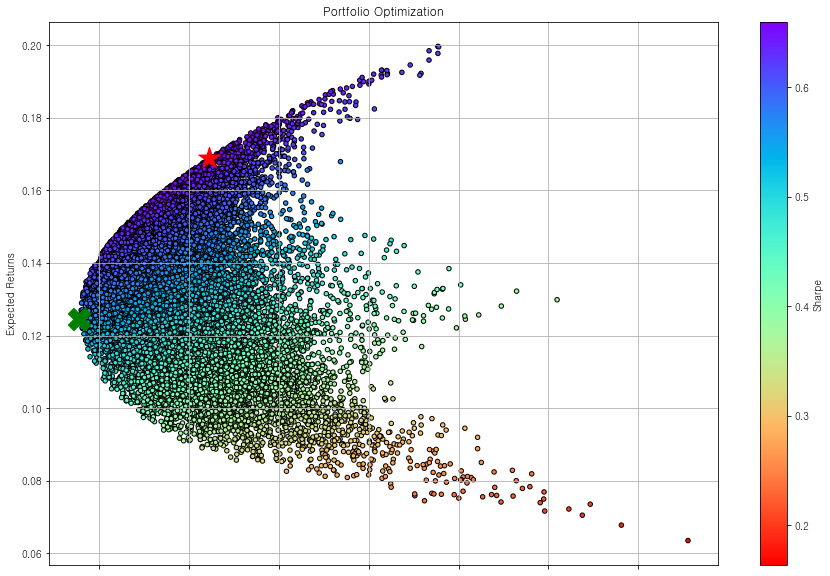

In [22]:
df.plot.scatter(x='Risk', y='Returns', c='Sharpe', 
                cmap='rainbow_r', edgecolors='k', 
                figsize=(15,10), grid=True) 

plt.scatter(x = max_sharpe['Risk'], y = max_sharpe['Returns'], 
            c ='r', marker='*', s = 500)       # Mean-Varinance portfolio: *
plt.scatter(x = min_risk['Risk'], y = min_risk['Returns'], 
            c = 'g', marker='X', s = 500)      # Mininum-Variance portfolio: X

plt.title('Portfolio Optimization') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.show();